In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.arima.utils import ndiffs
from datetime import datetime
from datetime import date
from sklearn.metrics import mean_squared_error
import math
import json

# ARIMA (Auto-Regression Integrated Moving Average) Model

The ARIMA model forecasts variant-cases one 'vaccine'-step at a time. It is fundamentally used to predict time-series; however, through the following parametric operations, we can use it to predict variant cases from vaccine data. 

Let $\alpha$ be the target function s.t. $vaccines = \alpha (t)$.

Let $\beta$ be the target function s.t. $variants = \beta (t)$.

Then, through parameterization, $t = \alpha^{-1}(vaccines)$. 

Therefore, it follows then that $variants = \gamma (vaccines)$ where $\gamma(x) = \beta \alpha^{-1} (x)$.

So, assuming $\exists$ target functions $\alpha$ and $\beta$ that can be approximated, then $\exists$ a target function $\gamma$ that can also be approximated s.t. $variants = \gamma (vaccines)$.

Parameters:
1. p - lag order (# of lag observations in the model) 
2. d - differencing degree (# of times the data is differenced)
3. q - window size

Follow instructions in each section to determine p, d, q parameters for vaccine/variants (It is currently set to California). The current data corresponds to sample collected after February 1st 2021.



# Loading Data

In [ ]:
value = [
    ('AK', 'Alaska'),
    ('AL', 'Alabama'),
    ('AZ', 'Arizona'),
    ('AR', 'Arkansas'),
    ('CA', 'California'),
    ('CO', 'Colorado'),
    ('CT', 'Connecticut'),
    ('DE', 'Delaware'),
    ('FL', 'Florida'),
    ('GA', 'Georgia'),
    ('HI', 'Hawaii'),
    ('ID', 'Idaho'),
    ('IL', 'Illinois'),
    ('IN', 'Indiana'),  
    ('IA', 'Iowa'),
    ('KS', 'Kansas'),
    ('KY', 'Kentucky'),
    ('LA', 'Louisiana'),
    ('ME', 'Maine'),
    ('MD', 'Maryland'),
    ('MA', 'Massachusetts'),
    ('MI', 'Michigan'),
    ('MN', 'Minnesota'),
    ('MS', 'Mississippi'),
    ('MO', 'Missouri'),
    ('MT', 'Montana'),
    ('NE', 'Nebraska'),
    ('NV', 'Nevada'),
    ('NH', 'New Hampshire'),
    ('NJ', 'New Jersey'),
    ('NM', 'New Mexico'),
    ('NY', 'New York State'),
    ('NC', 'North Carolina'),
    ('ND', 'North Dakota'),
    ('OH', 'Ohio'),
    ('OK', 'Oklahoma'),
    ('OR', 'Oregon'),
    ('PA', 'Pennsylvania'),
    ('RI', 'Rhode Island'),
    ('SC', 'South Carolina'),
    ('SD', 'South Dakota'),
    ('TN', 'Tennessee'),
    ('TX', 'Texas'),
    ('UT', 'Utah'),
    ('VT', 'Vermont'),
    ('VA', 'Virginia'),
    ('WA', 'Washington'),
    ('WV', 'West Virginia'),
    ('WI', 'Wisconsin'),
    ('WY', 'Wyoming'),
    ('AS', 'American Samoa'),
    ('DC', 'District of Columbia'),
    ('FM', 'Micronesia'),
    ('GU', 'Guam'),
    ('MH', 'Marshall Islands'),
    ('MP', 'Northern Mariana Islands'),
    ('PR', 'Puerto Rico'),
    ('PW', 'Palau'),
    ('VI', 'Virgin Islands')
]

codes = [a for a, b in value]
names = [b for a, b in value]

to_codes, to_names = {}, {}
for i in range(len(value)):
    to_codes[names[i]] = codes[i]
    to_names[codes[i]] = names[i]

# Code from Basel

In [ ]:
# Parsing variant cases
df = pd.read_csv('https://raw.githubusercontent.com/USATODAY/covid-variants/master/!combined.csv')
df.columns = ['Date', 'State', 'B.1.1.7', 'P.1', 'B.1.351', 'Total']
states = list(set(df['State'].to_list()))
states.sort()

variants_per_state = {}
for state in states:
  name = to_names[str(state)]
  variants_per_state[name] = df[df['State'] == state]
  variants_per_state[name] = variants_per_state[name].reset_index(drop=True).dropna()

# code from Andrew

In [ ]:
# Parsing vaccine data
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
states = list(set(df['location'].to_list()))
states.sort()
vaccine_per_state = {}
for state in states:
  vaccine_per_state[state] = df[df['location'] == state]
  vaccine_per_state[state] = vaccine_per_state[state].reset_index(drop=True).dropna()

# code from Andrew

In [ ]:
# Parsing total cases
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
parse = list(df.columns)
parse = list(filter(lambda x: '/21' in x and '/21/20' not in x, parse))
df = df[['Province_State'] + parse]
cases_per_state = {}
states = list(set(df['Province_State'].to_list()))
states.sort()

for state in states:
  data = df[df['Province_State'] == state]
  data = data.reset_index(drop=True)
  data = data[parse]
  cases_per_state[state] = pd.DataFrame(data.sum(axis=0)).reset_index()
  cases_per_state[state].columns = ['Date', 'Total_Cases']

# code from Andrew

In [ ]:
# Parsing to time series

# Start Date for data recording
start_date = date(2021, 2, 1)

def time_vaccine_state_data(state):
  vac_t = {}
  for index, row in vaccine_per_state[str(state)].iterrows():
    cur_date = row['date']
    cur_date = datetime.strptime(cur_date, "%Y-%m-%d").date()
    diff = cur_date - start_date
    vac_t[diff.days] = row['total_vaccinations']
  return vac_t

def time_variant_state_data(state):
  var_t = {}
  for index, row in variants_per_state[str(state)].iterrows():
    cur_date = row['Date']
    cur_date = datetime.strptime(cur_date, "%Y-%m-%d").date()
    diff = cur_date - start_date
    var_t[diff.days] = [max(row['B.1.1.7'], 1), max(row['P.1'], 1), max(row['B.1.351'], 1)]
  return var_t

def time_total_state_data(state):
  cases_t = {}
  for index, row in cases_per_state[str(state)].iterrows():
    cur_date = row['Date']
    cur_date = datetime.strptime(cur_date, '%m/%d/%y').date()
    diff = cur_date - start_date
    cases_t[diff.days] = row['Total_Cases']
  return cases_t

# Finding inputs and visualisations

In [ ]:
# Conglomerating inputs
'''
  @param is the name of the state
  returns a list of lists. Each list-element is [a, b, c, d, e]
  a = Day number (from start date)
  b = Number of cumulative B.1.1.7 cases from day 1 to day a
  c = Number of cumulative P.1 cases from day 1 to day a
  d = Number of cumulative B.1.351 cases from day 1 to day a
  e = Total wild-strain cases from day 1 to day a
'''
def timed_cases(state):
  case_c_t = []
  var_t = time_variant_state_data(state)
  cases_t = time_total_state_data(state)
  for v in var_t:
    if v < 0:
      continue
    cases = cases_t[v]
    case_c_t.append([v] + var_t[v] + [cases - sum(var_t[v])])
  return case_c_t

def timed_vaccine(state):
  vaccine_t = []
  vac_t = time_vaccine_state_data(state)
  for v in vac_t:
    if v < 0:
      continue
    vaccine_t.append([v] + [vac_t[v]])
  return vaccine_t

In [ ]:
def visualize_everything(state):
  c = np.asarray(timed_vaccine(state))
  d = np.asarray(timed_cases(state))
  fig, axs = plt.subplots(2, 3)
  axs[0, 0].set_title("Vaccine delivery for " + state + "\n")
  axs[0, 0].plot(c[:,0], c[:,1])
  axs[0, 1].set_title("B.1.1.7 in " + state  + "\n")
  axs[0, 1].plot(d[:,0], d[:,1])
  axs[0, 2].set_title("P.1 in " + state + "\n")
  axs[0, 2].plot(d[:,0], d[:,2])
  axs[1, 0].set_title("B.1.351 in " + state + "\n")
  axs[1, 0].plot(d[:,0], d[:,3])
  axs[1, 1].set_title("Wildstrain in " + state + "\n")
  axs[1, 1].plot(d[:,0], d[:,4])
  plt.subplots_adjust(left=0, bottom=0, right=1.0, top=1.0, wspace=1, hspace=1.0)

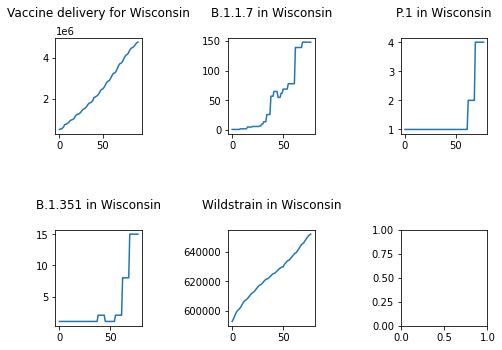

In [ ]:
visualize_everything("Wisconsin")

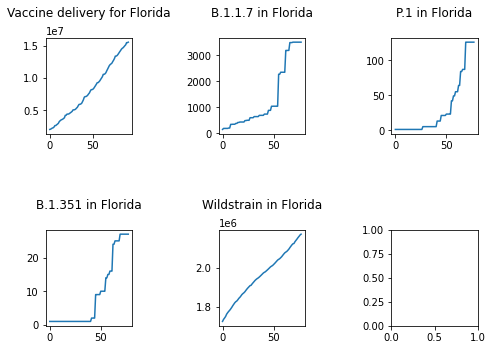

In [ ]:
visualize_everything("Florida")

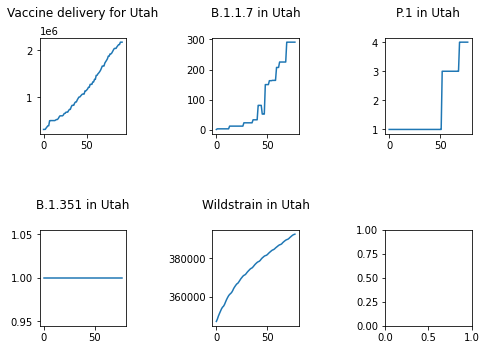

In [ ]:
visualize_everything("Utah")

# VACCINE: Differencing Degree (D)

How many differences are needed to make the data stationary

In [ ]:
# sanity check
timed_vaccine("California")[1][1] - timed_vaccine("California")[0][1]

90533.0

In [ ]:
# Produces 'degree' differenced lst, lst has to correspond to vaccine data
# ex. lst = timed_vaccine("California")
def diff_vaccine(lst, degree):
  initial_degree = degree
  def rand(lst, degree):
    for i in range(len(lst)-1, 0, -1):
      lst[i][1] = lst[i][1] - lst[i-1][1]
    if (degree == 1):
      return lst[degree+1:len(lst)]
    else:
      return rand(lst, degree - 1)
  return rand(lst, degree)

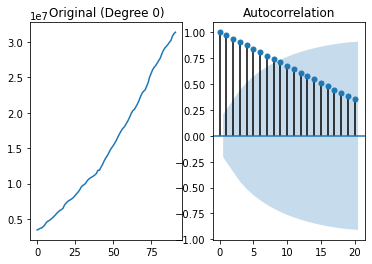

<Figure size 432x288 with 0 Axes>

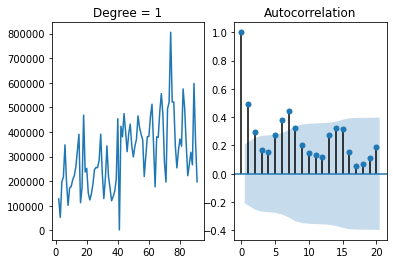

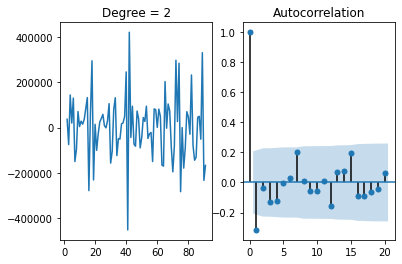

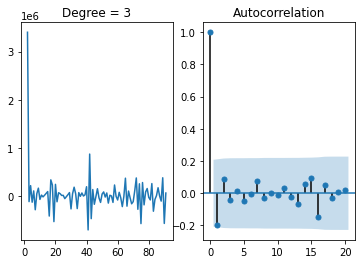

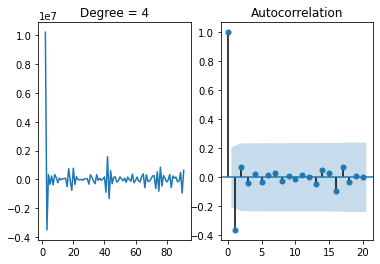

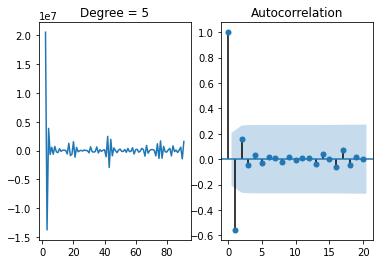

ADF test yields  1
KPSS test yields  2
PP test yields  1
Recommended degree =  2


2

In [ ]:
# Plots all the degree-differenced graph for a state upto the max-degree.
# Qualitative decision might be needed for each d(?)
def plot_vaccine_degree(state, max_degree):
  fig, axs = plt.subplots(1, 2)
  axs[0].set_title("Original (Degree 0)")
  c = np.asarray(timed_vaccine(state))
  axs[0].plot(c[:,0], c[:,1])
  plot_acf(c[:,1], ax=axs[1])
  plt.figure()
  plt.show()
  for i in range(max_degree):
    fig, axs = plt.subplots(1, 2)
    state_vacc = np.asarray(diff_vaccine(timed_vaccine(state), i+1))
    title1 = "Degree = " + str(i+1)
    axs[0].set_title(title1)
    axs[0].plot(state_vacc[:,0], state_vacc[:,1])
    plot_acf(state_vacc[:,1], ax=axs[1])
    plt.show()
  adf = ndiffs(c[:,1], test='adf')
  kpss = ndiffs(c[:,1], test='kpss')
  pp = ndiffs(c[:,1], test='pp')
  print("ADF test yields ", adf)
  print("KPSS test yields ", kpss)
  print("PP test yields ", pp)
  rec_degree = math.ceil((adf + kpss + pp) / 3)
  print("Recommended degree = ", rec_degree)
  return rec_degree
  
plot_vaccine_degree("California", 5)

In [ ]:
def vaccine_arima_d(state):
  # adf, kpss, pp are various statistical tests that can 
  # determine what an ideal differencing degree is.
  # we just return the first integer >= the average of 
  # the results of these tests.
  c = np.asarray(timed_vaccine(state))
  adf = ndiffs(c[:,1], test='adf')
  kpss = ndiffs(c[:,1], test='kpss')
  pp = ndiffs(c[:,1], test='pp')
  rec_degree = math.ceil((adf + kpss + pp) / 3)
  return rec_degree
  
vaccine_arima_d("California")

2

# VACCINE: Auto-Regression (P)

Finding how many auto-regression terms the model needs - measures how much does the data depend on its own lags. Use Partial Autocorrelalation (PACF) plots to find p. 

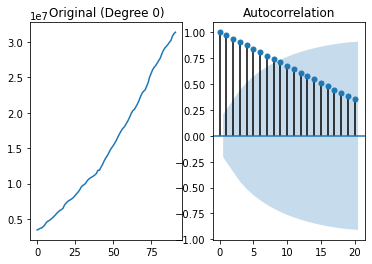

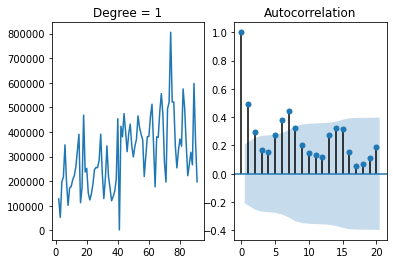

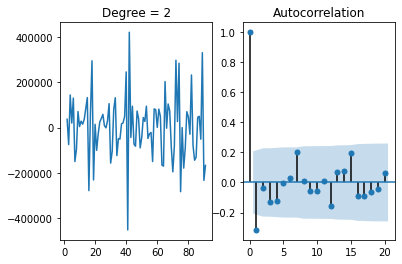

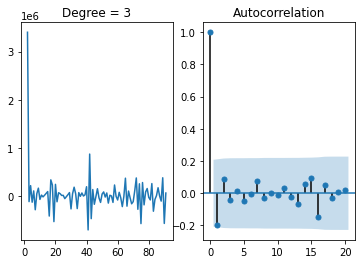

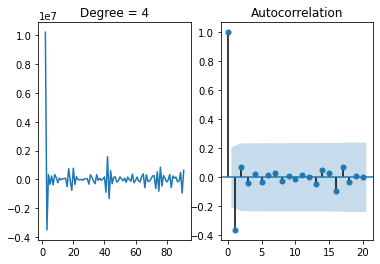

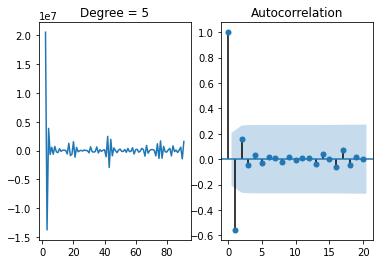

In [ ]:
# P value can be found by finding the last graph which has lags 
# (regions outside the blue-shade) that are not in the beginning.
# Right now this has to be done manually.
def plot_vaccine_ar(state, max_degree):
  fig, axs = plt.subplots(1, 2)
  axs[0].set_title("Original (Degree 0)")
  c = np.asarray(timed_vaccine(state))
  axs[0].plot(c[:,0], c[:,1])
  plot_acf(c[:,1], ax=axs[1])
  plt.show()
  for i in range(max_degree):
    fig, axs = plt.subplots(1, 2)
    state_vacc = np.asarray(diff_vaccine(timed_vaccine(state), i+1))
    title1 = "Degree = " + str(i+1)
    axs[0].set_title(title1)
    axs[0].plot(state_vacc[:,0], state_vacc[:,1])
    plot_acf(state_vacc[:,1], ax=axs[1])
    plt.show()
  
plot_vaccine_ar("California", 5)

# VACCINE: Finding Moving Average (Q)

An MA term is the error of the lagged forecast. In this section, we find the number of MA terms (its degree = q)

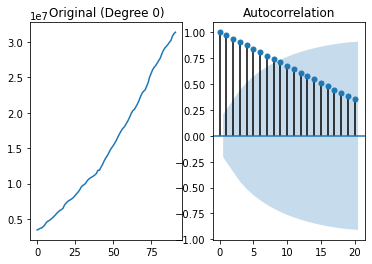

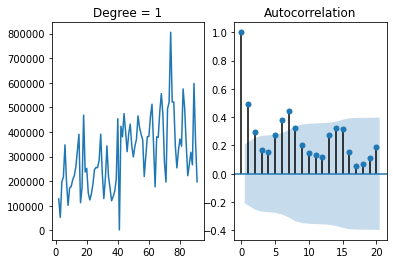

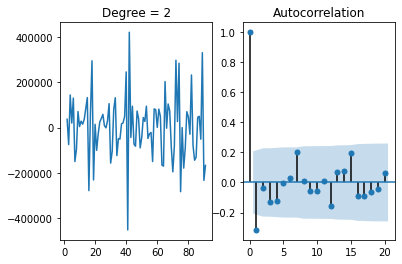

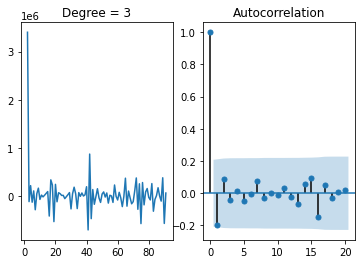

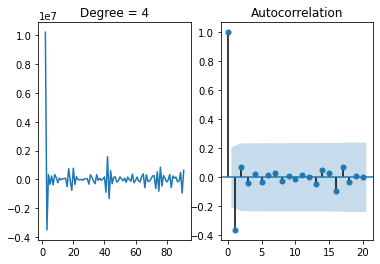

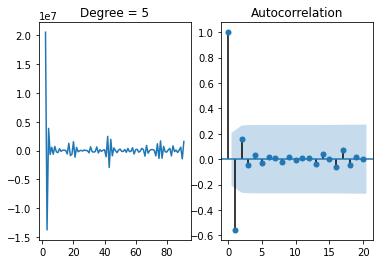

In [ ]:
# Choose the earliest degree which does not have >= 1 early-lags
# outside the confidence interval (closer to the beginning)
# P value can be found by finding the last graph which has lags 
# (regions outside the blue-shade) that are not in the beginning.
# Right now this has to be done manually.
def plot_vaccine_ma(state, max_degree):
  fig, axs = plt.subplots(1, 2)
  axs[0].set_title("Original (Degree 0)")
  c = np.asarray(timed_vaccine(state))
  axs[0].plot(c[:,0], c[:,1])
  plot_acf(c[:,1], ax=axs[1])
  plt.show()
  for i in range(max_degree):
    fig, axs = plt.subplots(1, 2)
    state_vacc = np.asarray(diff_vaccine(timed_vaccine(state), i+1))
    title1 = "Degree = " + str(i+1)
    axs[0].set_title(title1)
    axs[0].plot(state_vacc[:,0], state_vacc[:,1])
    plot_acf(state_vacc[:,1], ax=axs[1])
    plt.show()
  
plot_vaccine_ma("California", 5)

# VACCINE: Using parameters in ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [ ]:
def vaccine_arima_model(state, d, p, q):
  model = ARIMA(np.asarray(timed_vaccine(state))[:,1], order=(d,p,q))
  model_fit = model.fit(disp=0)
  print(model_fit.summary())
  return model_fit

cal_arima = vaccine_arima_model("California", 2, 2, 2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-para

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   89
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1164.225
Method:                       css-mle   S.D. of innovations         113581.203
Date:                Tue, 04 May 2021   AIC                           2340.451
Time:                        07:23:46   BIC                           2355.382
Sample:                             2   HQIC                          2346.469
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2960.7252    650.036      4.555      0.000    1686.677    4234.773
ar.L1.D2.y    -0.6096      0.206     -2.966      0.003      -1.012      -0.207
ar.L2.D2.y     0.2636      0.130      2.030      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECA

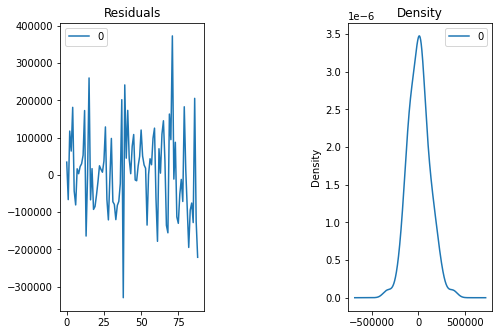

In [ ]:
# Verify this has ~0 mean and uniform variance
def plot_residuals(model_fit):
  residuals = pd.DataFrame(model_fit.resid)
  fig, ax = plt.subplots(1,2)
  residuals.plot(title="Residuals", ax=ax[0])
  residuals.plot(kind='kde', title='Density', ax=ax[1])
  plt.subplots_adjust(left=0, bottom=0, right=1.0, top=1.0, wspace=1, hspace=1.0)
  plt.show()

plot_residuals(cal_arima)

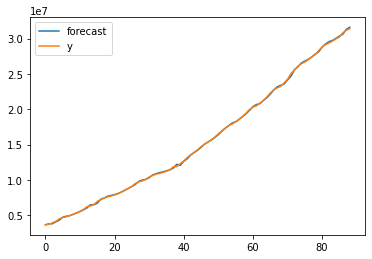

In [ ]:
def arima_actualvspredicted(model_fit):
  model_fit.plot_predict(dynamic=False)
  plt.show()

arima_actualvspredicted(cal_arima)

# VARIANTS: Differencing Degree (D)

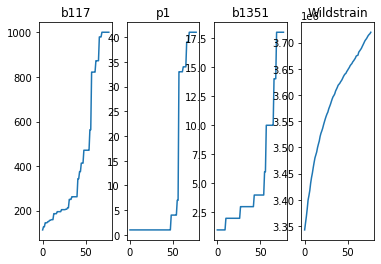

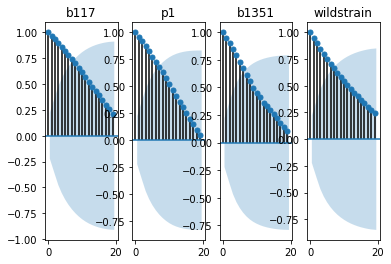

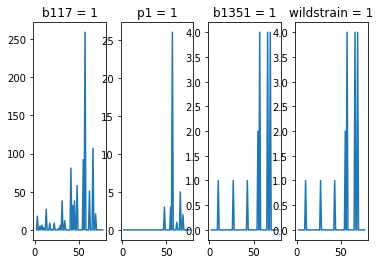

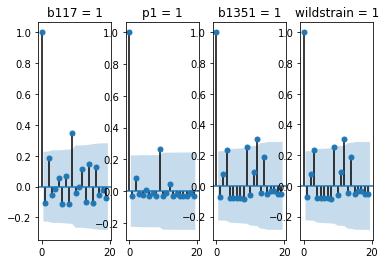

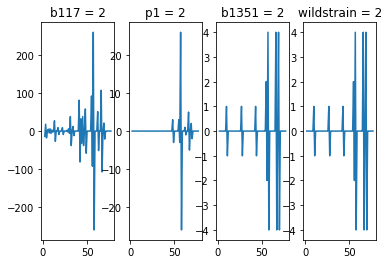

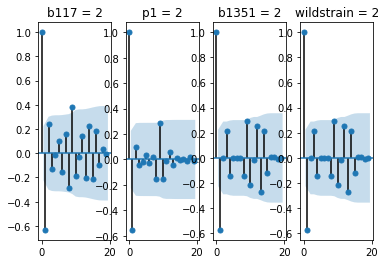

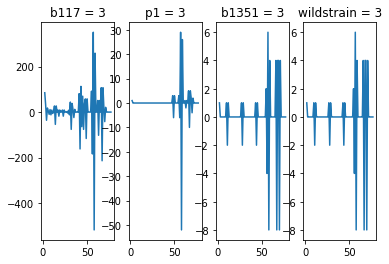

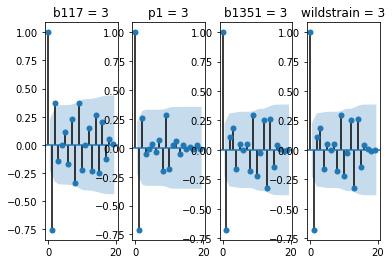

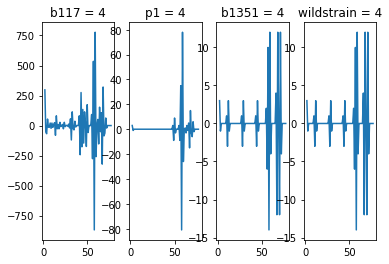

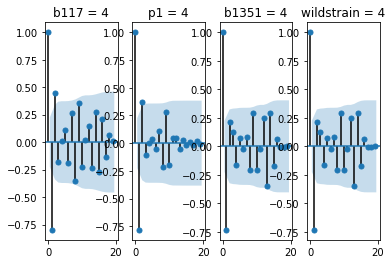

Recommended degree for b117 =  1
Recommended degree for p1 =  1
Recommended degree for b1351 =  1
Recommended degree for wildstrain =  1


[1, 1, 1, 1]

<Figure size 432x288 with 0 Axes>

In [ ]:
# Produces 'degree' differenced lst, lst has to correspond to single variant data
# ex. lst = timed_vaccine("California")
def diff_variant(lst, degree):
  initial_degree = degree
  def rand(lst, degree):
    for i in range(len(lst)-1, 0, -1):
      lst[i][1] = lst[i][1] - lst[i-1][1]
    if (degree == 1):
      return lst[degree+1:len(lst)]
    else:
      return rand(lst, degree - 1)
  return rand(lst, degree)

def use_diff_variant(state, degree):
  b117, p1, b1351, wildstrain = [], [], [], []
  cases = timed_cases(state)
  for i in range(len(cases)):
    b117.append([cases[i][0], cases[i][1]])
    p1.append([cases[i][0], cases[i][2]])
    b1351.append([cases[i][0], cases[i][3]])
    wildstrain.append([cases[i][0], cases[i][3]])
  b117 = diff_variant(b117, degree)
  p1 = diff_variant(p1, degree)
  b1351 = diff_variant(b1351, degree)
  wildstrain = diff_variant(wildstrain, degree)
  a = {}
  a["b117"] = np.copy(b117)
  a["p1"] = np.copy(p1)
  a["b1351"] = np.copy(b1351)
  a["wildstrain"] = np.copy(wildstrain)
  return a

# Plots all the degree-differenced graph for a state upto the max-degree.
# Qualitative decision might be needed for each d(?)
def plot_variant_degree(state, max_degree):
  fig, axs = plt.subplots(1, 4)
  c = np.asarray(timed_cases(state))
  l1 = axs[0].plot(c[:,0], c[:,1])
  l2 = axs[1].plot(c[:,0], c[:,2])
  l3 = axs[2].plot(c[:,0], c[:,3])
  l4 = axs[3].plot(c[:,0], c[:,4])
  axs[0].set_title("b117")
  axs[1].set_title("p1")
  axs[2].set_title("b1351")
  axs[3].set_title("Wildstrain")
  plt.show()
  fig, axs = plt.subplots(1, 4)
  plot_acf(c[:,1], ax=axs[0])
  plot_acf(c[:,2], ax=axs[1])
  plot_acf(c[:,3], ax=axs[2])
  plot_acf(c[:,4], ax=axs[3])
  axs[0].set_title("b117")
  axs[1].set_title("p1")
  axs[2].set_title("b1351")
  axs[3].set_title("wildstrain")
  plt.show()
  for i in range(max_degree):
    state_vacc = use_diff_variant(state, i+1)
    fig, axs = plt.subplots(1, 4)
    b117 = state_vacc["b117"]
    p1 = state_vacc["p1"]
    b1351 = state_vacc["b1351"]
    wildstrain = state_vacc["wildstrain"]
    l1 = axs[0].plot(b117[:,0], b117[:,1])
    l2 = axs[1].plot(p1[:,0], p1[:,1])
    l3 = axs[2].plot(b1351[:,0], b1351[:,1])
    l4 = axs[3].plot(wildstrain[:,0], wildstrain[:,1])
    title1 = "b117 = " + str(i+1)
    title2 = "p1 = " + str(i+1)
    title3 = "b1351 = " + str(i+1)
    title4 = "wildstrain = " + str(i+1)
    axs[0].set_title(title1)
    axs[1].set_title(title2)
    axs[2].set_title(title3)
    axs[3].set_title(title4)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    plot_acf(b117[:,1], ax=axs[0])
    plot_acf(p1[:,1], ax=axs[1])
    plot_acf(b1351[:,1], ax=axs[2])
    plot_acf(wildstrain[:,1], ax=axs[3])
    axs[0].set_title(title1)
    axs[1].set_title(title2)
    axs[2].set_title(title3)
    axs[3].set_title(title4)   
    plt.show()
  plt.subplots_adjust(left=0, bottom=0, right=1.0, top=1.0, wspace=1, hspace=1.0)
  def find_val(lst):
    adf = ndiffs(lst, test='adf')
    kpss = ndiffs(lst, test='kpss')
    pp = ndiffs(lst, test='pp')
    rec_degree = math.ceil((adf + kpss + pp) / 3)
    return rec_degree
  print("Recommended degree for b117 = ", find_val(c[:,1]))
  print("Recommended degree for p1 = ", find_val(c[:,2]))
  print("Recommended degree for b1351 = ", find_val(c[:,3]))
  print("Recommended degree for wildstrain = ", find_val(c[:,4]))
  return [find_val(c[:,1]), find_val(c[:,2]), find_val(c[:,3]), find_val(c[:,4])]
  
plot_variant_degree("California", 4)

In [ ]:
def diff_variant(lst, degree):
  initial_degree = degree
  def rand(lst, degree):
    for i in range(len(lst)-1, 0, -1):
      lst[i][1] = lst[i][1] - lst[i-1][1]
    if (degree == 1):
      return lst[degree+1:len(lst)]
    else:
      return rand(lst, degree - 1)
  return rand(lst, degree)


def variant_arima_d(state):
  c = np.asarray(timed_cases(state))
  def find_val(lst):
    adf = ndiffs(lst, test='adf')
    kpss = ndiffs(lst, test='kpss')
    pp = ndiffs(lst, test='pp')
    rec_degree = math.ceil((adf + kpss + pp) / 3)
    return rec_degree
  b117 = find_val(c[:,1])
  p1 = find_val(c[:,2])
  b1351 = find_val(c[:,3])
  wildstrain = find_val(c[:,4])
  print("Recommended degree for b117 = ", b117)
  print("Recommended degree for p1 = ", p1)
  print("Recommended degree for b1351 = ", b1351)
  print("Recommended degree for wildstrain = ", wildstrain)
  return [b117, p1, b1351, wildstrain]
  
variant_arima_d("California")

Recommended degree for b117 =  1
Recommended degree for p1 =  1
Recommended degree for b1351 =  1
Recommended degree for wildstrain =  1


[1, 1, 1, 1]

# VARIANTS: Auto-Regression (P)

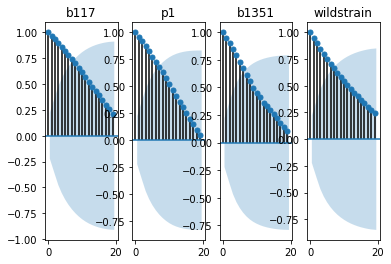

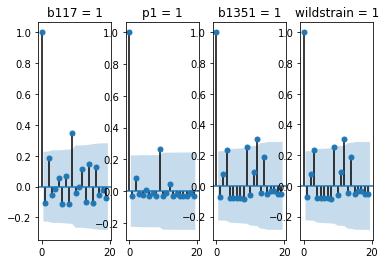

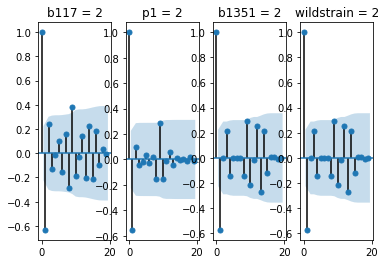

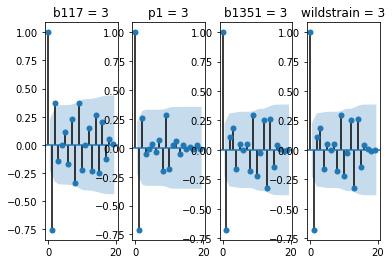

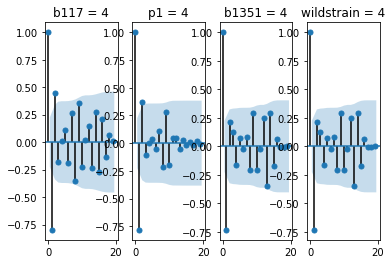

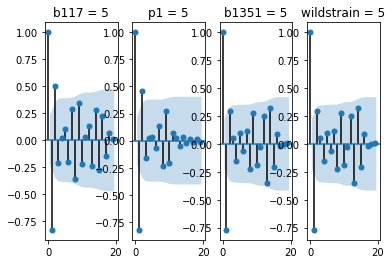

In [ ]:
# P value can be found by finding the last graph which has lags 
# (regions outside the blue-shade) that are in the middle/end.
# Right now this has to be done manually.
def plot_variant_ar(state, max_degree):
  c = np.asarray(timed_cases(state))
  fig, axs = plt.subplots(1, 4)
  plot_acf(c[:,1], ax=axs[0])
  plot_acf(c[:,2], ax=axs[1])
  plot_acf(c[:,3], ax=axs[2])
  plot_acf(c[:,4], ax=axs[3])
  axs[0].set_title("b117")
  axs[1].set_title("p1")
  axs[2].set_title("b1351")
  axs[3].set_title("wildstrain")
  plt.show()
  for i in range(max_degree):
      state_vacc = use_diff_variant(state, i+1)
      b117 = state_vacc["b117"]
      p1 = state_vacc["p1"]
      b1351 = state_vacc["b1351"]
      wildstrain = state_vacc["wildstrain"]
      title1 = "b117 = " + str(i+1)
      title2 = "p1 = " + str(i+1)
      title3 = "b1351 = " + str(i+1)
      title4 = "wildstrain = " + str(i+1)
      fig, axs = plt.subplots(1, 4)
      plot_acf(b117[:,1], ax=axs[0])
      plot_acf(p1[:,1], ax=axs[1])
      plot_acf(b1351[:,1], ax=axs[2])
      plot_acf(wildstrain[:,1], ax=axs[3])
      axs[0].set_title(title1)
      axs[1].set_title(title2)
      axs[2].set_title(title3)
      axs[3].set_title(title4)   
      plt.show()
  
plot_variant_ar("California", 5)

# VARIANTS: Finding Moving Average (Q)

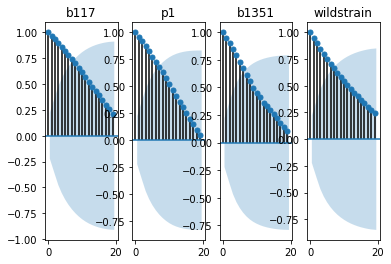

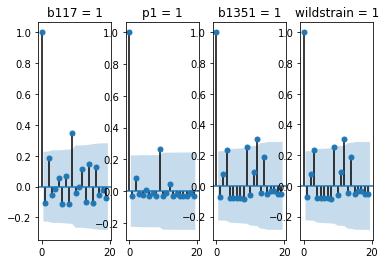

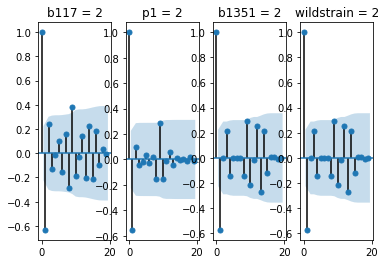

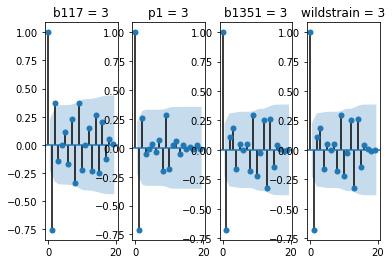

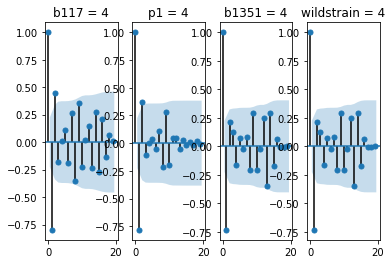

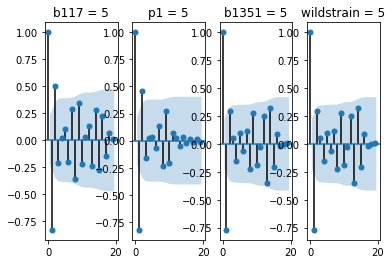

In [ ]:
# Choose the earliest degree without >= 1 early-lags
# outside the confidence interval.
# Right now this has to be done manually.
def plot_variant_ma(state, max_degree):
  c = np.asarray(timed_cases(state))
  fig, axs = plt.subplots(1, 4)
  plot_acf(c[:,1], ax=axs[0])
  plot_acf(c[:,2], ax=axs[1])
  plot_acf(c[:,3], ax=axs[2])
  plot_acf(c[:,4], ax=axs[3])
  axs[0].set_title("b117")
  axs[1].set_title("p1")
  axs[2].set_title("b1351")
  axs[3].set_title("wildstrain")
  plt.show()
  for i in range(max_degree):
      state_vacc = use_diff_variant(state, i+1)
      b117 = state_vacc["b117"]
      p1 = state_vacc["p1"]
      b1351 = state_vacc["b1351"]
      wildstrain = state_vacc["wildstrain"]
      title1 = "b117 = " + str(i+1)
      title2 = "p1 = " + str(i+1)
      title3 = "b1351 = " + str(i+1)
      title4 = "wildstrain = " + str(i+1)
      fig, axs = plt.subplots(1, 4)
      plot_acf(b117[:,1], ax=axs[0])
      plot_acf(p1[:,1], ax=axs[1])
      plot_acf(b1351[:,1], ax=axs[2])
      plot_acf(wildstrain[:,1], ax=axs[3])
      axs[0].set_title(title1)
      axs[1].set_title(title2)
      axs[2].set_title(title3)
      axs[3].set_title(title4)   
      plt.show()

plot_variant_ma("California", 5)

# VARIANTS: Using parameters in ARIMA

In [ ]:
def b117_variant_arima_model(state, d, p, q):
  model = ARIMA(np.asarray(timed_cases(state))[:,1], order=(d,p,q))
  model_fit = model.fit(disp=0)
  print(model_fit.summary())
  return model_fit

def p1_variant_arima_model(state, d, p, q):
  model = ARIMA(np.asarray(timed_cases(state))[:,2], order=(d,p,q))
  model_fit = model.fit(disp=0)
  print(model_fit.summary())
  return model_fit

def b1351_variant_arima_model(state, d, p, q):
  model = ARIMA(np.asarray(timed_cases(state))[:,3], order=(d,p,q))
  model_fit = model.fit(disp=0)
  print(model_fit.summary())
  return model_fit

def wildstrain_arima_model(state, d, p, q):
  model = ARIMA(np.asarray(timed_cases(state))[:,4], order=(d,p,q))
  model_fit = model.fit(disp=0)
  print(model_fit.summary())
  return model_fit

In [ ]:
b117_cal_arima = b117_variant_arima_model("California", 1, 2, 2)
p1_cal_arima = p1_variant_arima_model("California", 1, 2, 1)
b1351_cal_arima = b1351_variant_arima_model("California", 1, 2, 1)
wildstrain_cal_arima = wildstrain_arima_model("California", 1, 2, 1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   76
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -379.198
Method:                       css-mle   S.D. of innovations             34.485
Date:                Tue, 04 May 2021   AIC                            768.397
Time:                        07:24:00   BIC                            780.050
Sample:                             2   HQIC                           773.054
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2326      0.162      1.438      0.150      -0.084       0.550
ar.L1.D2.y    -0.5785      0.280     -2.066      0.039      -1.127      -0.030
ma.L1.D2.y    -0.5595      0.301     -1.856      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   76
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -92.806
Method:                       css-mle   S.D. of innovations              0.796
Date:                Tue, 04 May 2021   AIC                            193.613
Time:                        07:24:01   BIC                            202.936
Sample:                             2   HQIC                           197.339
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.004      2.124      0.034       0.001       0.015
ar.L1.D2.y    -0.1139      0.114     -0.999      0.318      -0.337       0.109
ma.L1.D2.y    -1.0000      0.040    -24.730      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

# VARIANTS: Error Check

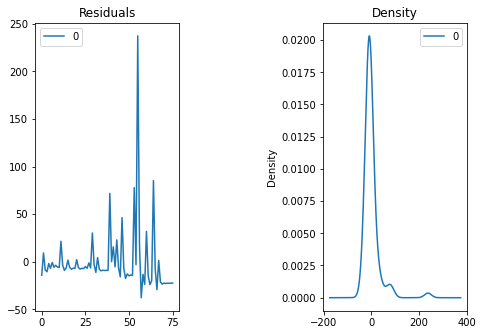

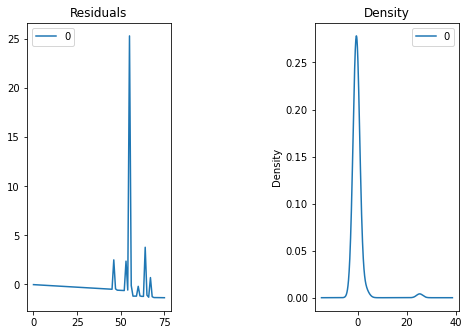

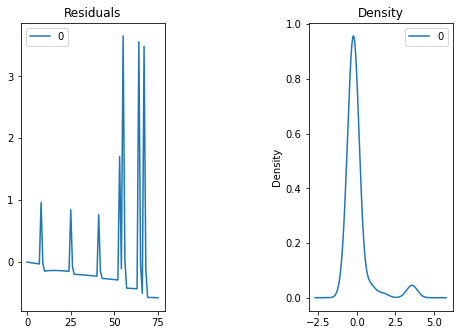

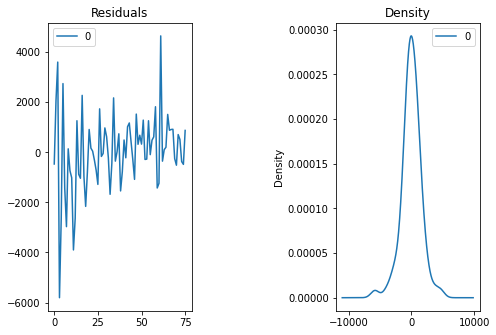

In [ ]:
# verify that all the density plots have a mean of 0 and a uniform variance
# verify that the residual plots are 'roughly' stationary

plot_residuals(b117_cal_arima)
plot_residuals(p1_cal_arima)
plot_residuals(b1351_cal_arima)
plot_residuals(wildstrain_cal_arima)

# VARIANT: Prediction

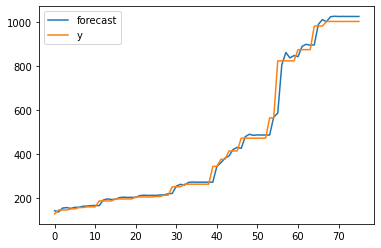

In [ ]:
# b117 variant forecast in California
arima_actualvspredicted(b117_cal_arima)

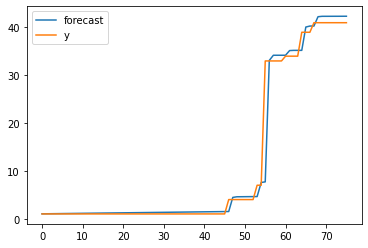

In [ ]:
# p1 variant forecast in California
arima_actualvspredicted(p1_cal_arima)

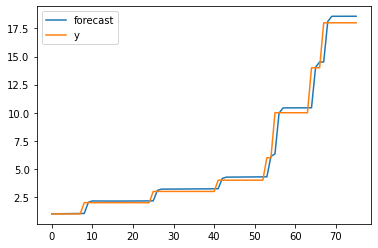

In [ ]:
# b1351 variant forecast in California
arima_actualvspredicted(b1351_cal_arima)

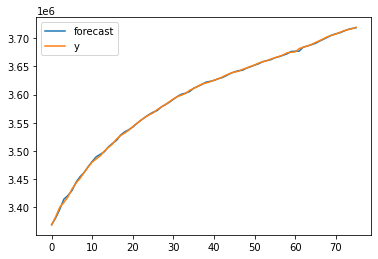

In [ ]:
# wildstrain variant forecast in California
arima_actualvspredicted(wildstrain_cal_arima)

# Predicting covid variant cases from vaccine data

In [ ]:
'''
  @param is the name of the state
  returns 2 lists:
    list1 is the vaccine data
    list2 is the variant data [a, b, c, d] where:
      a = Number of cumulative B.1.1.7 cases
      b = Number of cumulative P.1 cases
      c = Number of cumulative B.1.351 cases
      d = Total wild-strain cases
    The i'th element of list1 was recorded on the same day as the i'th element of list2
'''
def vaccine_variant_data(state):
  cases = timed_cases(state)
  vaccines = timed_vaccine(state)
  x_vaccine = []
  y_variant = []
  a = {}
  x_vaccine = []
  y_variant = []
  days = []
  for i in range(len(cases)):
    a[cases[i][0]] = 1
  for i in range(len(vaccines)):
    try:
      a[vaccines[i][0]] = a[vaccines[i][0]] + 1
    except:
      a[vaccines[i][0]] = 1
  for i in a.keys():
    if (a[i] == 2):
      days.append(i)
      x_vaccine.append(vaccines[i][1])
      y_variant.append([cases[i][1], cases[i][2], cases[i][3], cases[i][4]])
  return np.asarray(x_vaccine), np.asarray(y_variant)

In [ ]:
# visualize vaccine vs. variant
def visualize_cumulative_vaccine_vs_variant(state):
  vaccine, variant = vaccine_variant_data("California")
  plt.figure()
  plt.title("B117 vs. vaccines in " + state)
  plt.plot(vaccine, variant[:,0])
  plt.show()
  plt.figure()
  plt.title("P1 vs. vaccines in " + state)
  plt.plot(vaccine, variant[:,1])
  plt.show()
  plt.figure()
  plt.title("B1351 vs. vaccines in " + state)
  plt.plot(vaccine, variant[:,2])
  plt.show()
  plt.figure()
  plt.title("Wildstrain vs. vaccines in " + state)
  plt.plot(vaccine, variant[:,3])
  plt.show()

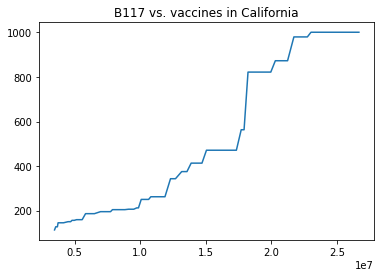

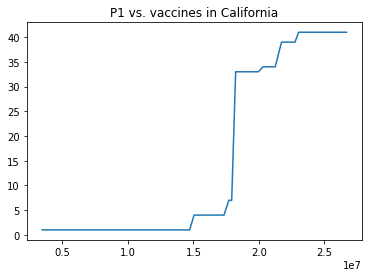

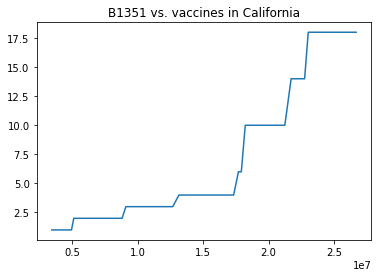

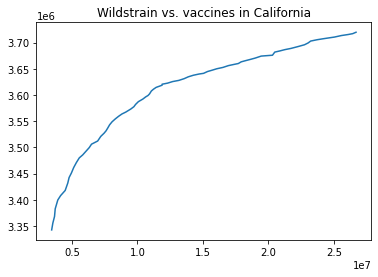

In [ ]:
visualize_cumulative_vaccine_vs_variant("California")

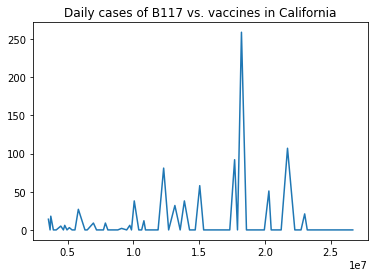

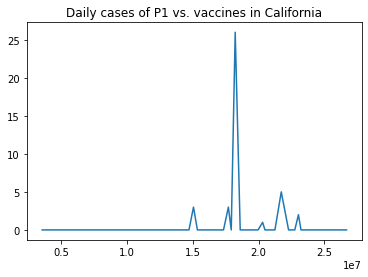

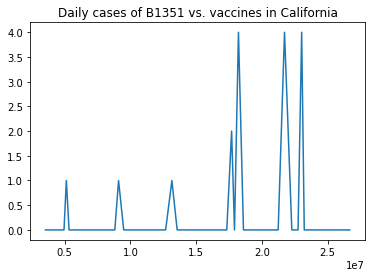

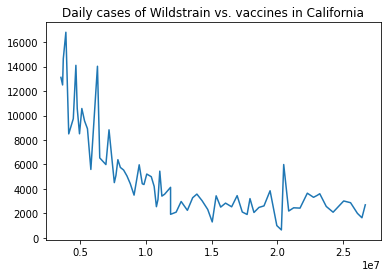

In [ ]:
def daily_cases(lst):
  for i in range(len(lst)-1, 0, -1):
    lst[i][0] = lst[i][0] - lst[i-1][0]
    lst[i][1] = lst[i][1] - lst[i-1][1]
    lst[i][2] = lst[i][2] - lst[i-1][2]
    lst[i][3] = lst[i][3] - lst[i-1][3]
  return lst[1:len(lst)]

def visualize_daily_vaccine_vs_variant(state):
  vaccine, variant = vaccine_variant_data("California")
  variant = daily_cases(variant)
  vaccine = vaccine[1:len(vaccine)]
  plt.figure()
  plt.title("Daily cases of B117 vs. vaccines in " + state)
  plt.plot(vaccine, variant[:,0])
  plt.show()
  plt.figure()
  plt.title("Daily cases of P1 vs. vaccines in " + state)
  plt.plot(vaccine, variant[:,1])
  plt.show()
  plt.figure()
  plt.title("Daily cases of B1351 vs. vaccines in " + state)
  plt.plot(vaccine, variant[:,2])
  plt.show()
  plt.figure()
  plt.title("Daily cases of Wildstrain vs. vaccines in " + state)
  plt.plot(vaccine, variant[:,3])
  plt.show()

visualize_daily_vaccine_vs_variant("California")

# Multivariate differencing degree (D)

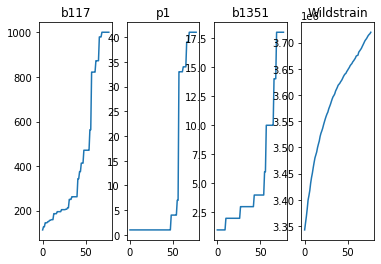

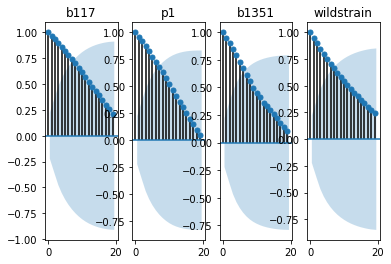

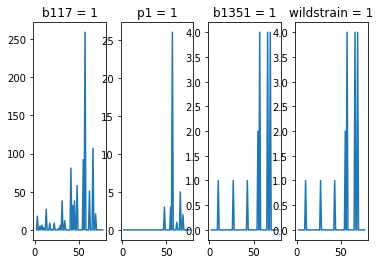

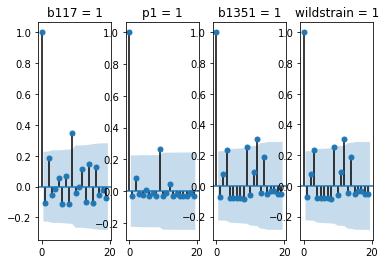

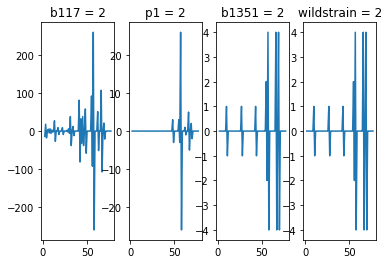

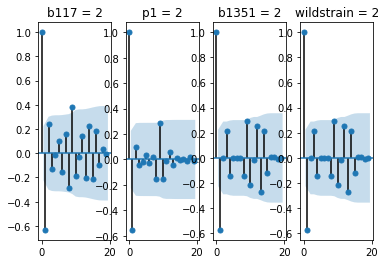

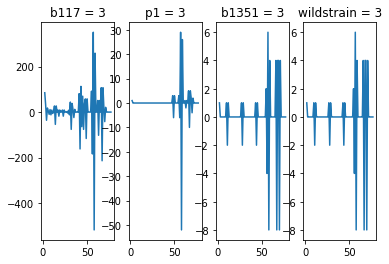

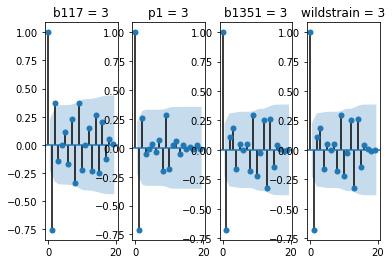

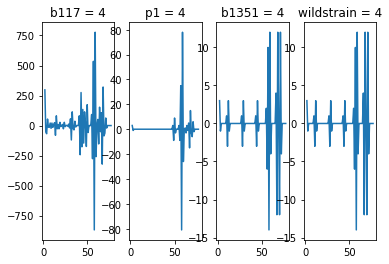

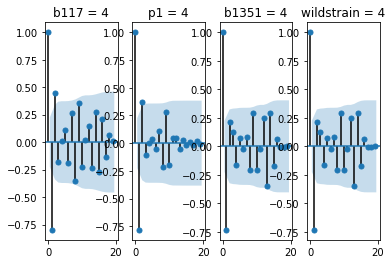

Recommended degree for b117 =  1
Recommended degree for p1 =  1
Recommended degree for b1351 =  1
Recommended degree for wildstrain =  1


[1, 1, 1, 1]

<Figure size 432x288 with 0 Axes>

In [ ]:
# Produces 'degree' differenced lst, lst has to correspond to single variant data
# ex. lst = timed_vaccine("California")
def diff_multivariate(lst, degree):
  initial_degree = degree
  def rand(lst, degree):
    for i in range(len(lst)-1, 0, -1):
      lst[i][0] = lst[i][0] - lst[i-1][0]
      lst[i][1] = lst[i][1] - lst[i-1][1]
      lst[i][2] = lst[i][2] - lst[i-1][2]
      lst[i][3] = lst[i][3] - lst[i-1][3]
    if (degree == 1):
      return lst[degree+1:len(lst)]
    else:
      return rand(lst, degree - 1)
  return rand(lst, degree)

def use_diff_multivariate(state, degree):
  b117, p1, b1351, wildstrain = [], [], [], []
  vaccine, variant = vaccine_variant_data(state)
  for i in range(len(variant)):
    b117.append([vaccine[i], variant[i][0]])
    p1.append([vaccine[i], variant[i][1]])
    b1351.append([vaccine[i], variant[i][2]])
    wildstrain.append([vaccine[i], variant[i][3]])
  b117 = diff_vaccine(b117, degree)
  p1 = diff_vaccine(p1, degree)
  b1351 = diff_vaccine(b1351, degree)
  wildstrain = diff_vaccine(wildstrain, degree)
  a = {}
  a["b117"] = np.copy(b117)
  a["p1"] = np.copy(p1)
  a["b1351"] = np.copy(b1351)
  a["wildstrain"] = np.copy(wildstrain)
  return a

# Plots all the degree-differenced graph for a state upto the max-degree.
# Qualitative decision might be needed for each d(?)
# The autocorrelation here is very iffy since it goes off data that is assumed to be
# only time-sensitive. So we do the following:
# variant = a(t) (from the assumption of ML - that there is a target function to be determined)
# vaccine = b(t) (from the assumption of ML - that there is a target function to be determined)
# variant = a b^-1 (vaccine), where our goal is to find a b^-1
# this is (probably) valid since a and b are monotonically increasing functions too
# for the autocorrelation we do variant*vaccine, so our final model would prooduce
# f(variant*vaccine) = (variant*vaccine)_predicted
# variant_predicted = (variant*vaccine)_predicted / vaccine_actual
# the obvious limitation here is that the model hides the time component (the impact is still to be determined)
def plot_multivariate_degree(state, max_degree):
  vaccine, variant = vaccine_variant_data(state)
  fig, axs = plt.subplots(1, 4)
  l1 = axs[0].plot(vaccine, variant[:,0])
  l2 = axs[1].plot(vaccine, variant[:,1])
  l3 = axs[2].plot(vaccine, variant[:,2])
  l4 = axs[3].plot(vaccine, variant[:,3])
  axs[0].set_title("b117")
  axs[1].set_title("p1")
  axs[2].set_title("b1351")
  axs[3].set_title("Wildstrain")
  plt.show()
  fig, axs = plt.subplots(1, 4)
  plot_acf(vaccine*variant[:,0], ax=axs[0])
  plot_acf(vaccine*variant[:,1], ax=axs[1])
  plot_acf(vaccine*variant[:,2], ax=axs[2])
  plot_acf(vaccine*variant[:,3], ax=axs[3])
  axs[0].set_title("b117")
  axs[1].set_title("p1")
  axs[2].set_title("b1351")
  axs[3].set_title("wildstrain")
  plt.show()
  for i in range(max_degree):
    state_vacc = use_diff_multivariate(state, i+1)
    fig, axs = plt.subplots(1, 4)
    b117 = state_vacc["b117"]
    p1 = state_vacc["p1"]
    b1351 = state_vacc["b1351"]
    wildstrain = state_vacc["wildstrain"]
    l1 = axs[0].plot(b117[:,0], b117[:,1])
    l2 = axs[1].plot(p1[:,0], p1[:,1])
    l3 = axs[2].plot(b1351[:,0], b1351[:,1])
    l4 = axs[3].plot(wildstrain[:,0], wildstrain[:,1])
    title1 = "b117 = " + str(i+1)
    title2 = "p1 = " + str(i+1)
    title3 = "b1351 = " + str(i+1)
    title4 = "wildstrain = " + str(i+1)
    axs[0].set_title(title1)
    axs[1].set_title(title2)
    axs[2].set_title(title3)
    axs[3].set_title(title4)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    plot_acf(b117[:,1]*b117[:,0], ax=axs[0])
    plot_acf(p1[:,1]*p1[:,0], ax=axs[1])
    plot_acf(b1351[:,1]*b135[:,0], ax=axs[2])
    plot_acf(wildstrain[:,1]*wildstrain[:,0], ax=axs[3])
    axs[0].set_title(title1)
    axs[1].set_title(title2)
    axs[2].set_title(title3)
    axs[3].set_title(title4)   
    plt.show()
  plt.subplots_adjust(left=1.0, bottom=0, right=1.0, top=1.0, wspace=1, hspace=1.0)
  def find_val(lst):
    adf = ndiffs(lst[:,0]*lst[:,1], test='adf')
    kpss = ndiffs(lst[:,0]*lst[:,1], test='kpss')
    pp = ndiffs(lst[:,0]*lst[:,1], test='pp')
    rec_degree = math.ceil((adf + kpss + pp) / 3)
    return rec_degree
  print("Recommended degree for b117 = ", find_val(b117))
  print("Recommended degree for p1 = ", find_val(p1))
  print("Recommended degree for b1351 = ", find_val(b1351))
  print("Recommended degree for wildstrain = ", find_val(wildstrain))
  return [find_val(b117), find_val(p1), find_val(b1351), find_val(wildstrain)]
  
plot_variant_degree("California", 4)

# Multivariate autoregression (P)


In [ ]:
# Use above figures to find the last graph which has lags 
# (regions outside the blue-shade) in the middle/end.
# Right now this has to be done manually.

# Multivariate Moving Average (Q)

In [ ]:
# Choose the earliest degree without >= 1 early-lags
# outside the confidence interval.

# Inserting Parameters into Multivariate ARIMA

In [ ]:
def b117_full_model(state, d, p, q):
  vaccine, variant = vaccine_variant_data(state)
  model = ARIMA(vaccine*variant[:,0], order=(d,p,q))
  model_fit = model.fit(disp=0)
  print(model_fit.summary())
  return model_fit


def p1_full_model(state, d, p, q):
  vaccine, variant = vaccine_variant_data(state)
  model = ARIMA(vaccine*variant[:,1], order=(d,p,q))
  model_fit = model.fit(disp=0)
  print(model_fit.summary())
  return model_fit


def b1351_full_model(state, d, p, q):
  vaccine, variant = vaccine_variant_data(state)
  model = ARIMA(vaccine*variant[:,2], order=(d,p,q))
  model_fit = model.fit(disp=0)
  print(model_fit.summary())
  return model_fit


def wildstrain_full_model(state, d, p, q):
  vaccine, variant = vaccine_variant_data(state)
  model = ARIMA(vaccine*variant[:,0], order=(d,p,q))
  model_fit = model.fit(disp=0)
  print(model_fit.summary())
  return model_fit

def full_arima_actualvspredicted(model_fit):
  model_fit.plot_predict(dynamic=False)
  plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   75
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1638.072
Method:                       css-mle   S.D. of innovations      737486120.069
Date:                Tue, 04 May 2021   AIC                           3282.144
Time:                        07:24:11   BIC                           3289.096
Sample:                             2   HQIC                          3284.920
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.591e+06   5.28e+07      0.049      0.961   -1.01e+08    1.06e+08
ar.L1.D2.y    -0.6219      0.088     -7.036      0.000      -0.795      -0.449
                                    Roots           

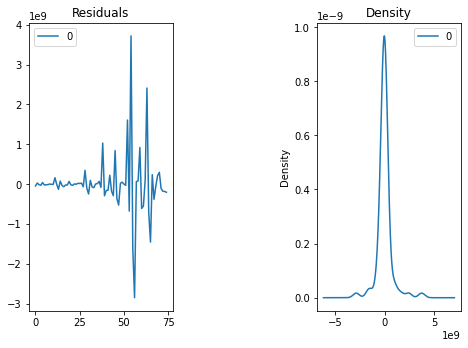

In [ ]:
# b117 (variant*vaccine)(t) prediction
b117_full_cal_arima = b117_full_model("California", 1, 2, 0)
plot_residuals(b117_full_cal_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available',

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   75
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1446.048
Method:                       css-mle   S.D. of innovations       56332312.841
Date:                Tue, 04 May 2021   AIC                           2900.095
Time:                        07:24:11   BIC                           2909.365
Sample:                             2   HQIC                          2903.796
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.376e+05        nan        nan        nan         nan         nan
ar.L1.D2.y    -0.0510      0.116     -0.438      0.661      -0.279       0.177
ma.L1.D2.y    -0.9394        nan        nan        n

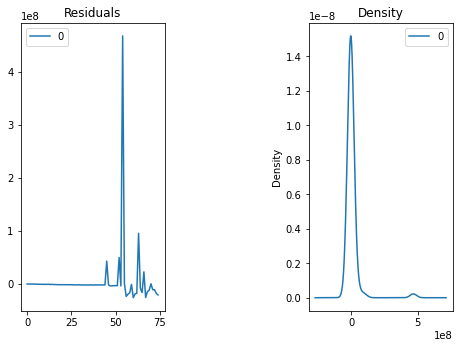

In [ ]:
# p1 (variant*vaccine)(t) prediction
p1_full_cal_arima = p1_full_model("California", 1, 2, 1)
plot_residuals(p1_full_cal_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   76
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1372.423
Method:                       css-mle   S.D. of innovations       16814844.166
Date:                Tue, 04 May 2021   AIC                           2752.846
Time:                        07:24:12   BIC                           2762.169
Sample:                             1   HQIC                          2756.572
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.276e+06   4.28e+06      1.468      0.142    -2.1e+06    1.47e+07
ar.L1.D.y      0.9494      0.068     13.964      0.000       0.816       1.083
ma.L1.D.y     -0.8719      0.095     -9.192      0.0

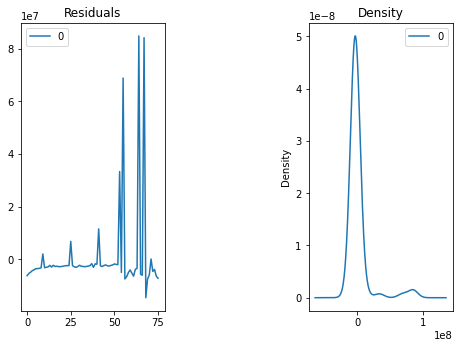

In [ ]:
# b1351 (variant*vaccine)(t) prediction
b1351_full_cal_arima = b1351_full_model("California", 1, 1, 1)
plot_residuals(b1351_full_cal_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   76
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1650.158
Method:                       css-mle   S.D. of innovations      649485882.683
Date:                Tue, 04 May 2021   AIC                           3308.316
Time:                        07:24:12   BIC                           3317.639
Sample:                             1   HQIC                          3312.042
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.464e+08   1.85e+08      1.873      0.061   -1.62e+07    7.09e+08
ar.L1.D.y      0.9578      0.050     19.109      0.000       0.860       1.056
ma.L1.D.y     -0.8755      0.074    -11.882      0.0

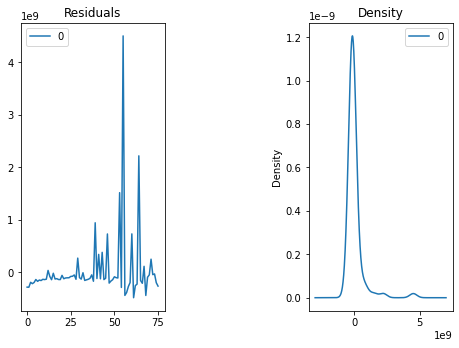

In [ ]:
# wildstrain (variant*vaccine)(t) prediction
wildstrain_full_cal_arima = wildstrain_full_model("California", 1, 1, 1)
plot_residuals(wildstrain_full_cal_arima)

# Predicting (Vaccine*Variant)(t) 

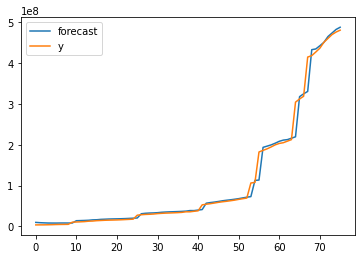

In [ ]:
# b1351 (vaccine*variant)(t)
full_arima_actualvspredicted(b1351_full_cal_arima)

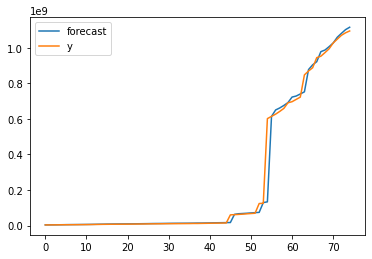

In [ ]:
# p1 (vaccine*variant)(t)
full_arima_actualvspredicted(p1_full_cal_arima)

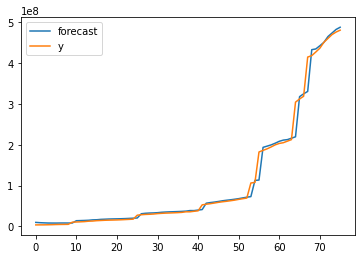

In [ ]:
# b1351 (vaccine*variant)(t)
full_arima_actualvspredicted(b1351_full_cal_arima)

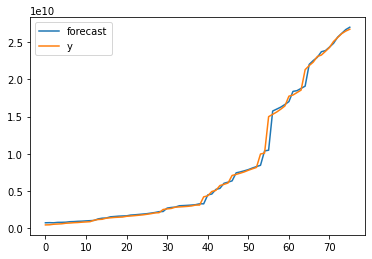

In [ ]:
# wildstrain (vaccine*variant)(t)
full_arima_actualvspredicted(wildstrain_full_cal_arima)

# Predicting Variant(t) through $\frac{(Vaccine*Variant)(t)}{Vaccine(t)}$ and Error Analysis

In [ ]:
def variant_arima(state, var, d, p, q):
  if (var == "b117"):
    bill = 0
  elif (var == "p1"):
    bill = 1
  elif (var == "b1351"):
    bill = 2
  else:
    bill = 3
  vaccine, variant = vaccine_variant_data(state)
  size = int(len(vaccine)*0.66)
  train, test = (vaccine*variant[:,bill])[0:size], (vaccine*variant[:,bill])[size:len(vaccine)]
  test_vaccine = vaccine[size:len(vaccine)]
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=(d, p, q))
    model_fit = model.fit()
    output = model_fit.forecast()
    y = output[0]/test_vaccine[t]
    predictions.append(y)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (y, obs/test_vaccine[t]))
  rmse = math.sqrt(mean_squared_error(test/test_vaccine, predictions))
  print('Test RMSE: %.3f' % rmse)
  print("\n\n\n")
  # plot forecasts against actual outcomes
  print(var, " prediction in the state of ", state)
  plt.plot(test_vaccine, test/test_vaccine, label="Actual")
  plt.plot(test_vaccine, predictions, color='red', label="Forecast")
  plt.legend(loc="upper right")
  plt.xlabel("# of vaccines")
  title = "# of cumulative " + var + " cases in " + state
  plt.ylabel(title)
  plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=469.560908, expected=471.000000
predicted=468.021116, expected=471.000000
predicted=470.919298, expected=471.000000
predicted=472.844140, expected=471.000000
predicted=472.270864, expected=563.000000
predicted=601.764558, expected=563.000000
predicted=631.577986, expected=822.000000
predicted=830.764134, expected=822.000000
predicted=1055.108564, expected=822.000000
predicted=818.886741, expected=822.000000
predicted=818.235370, expected=822.000000
predicted=827.924495, expected=873.000000
predicted=903.043875, expected=873.000000
predicted=901.546005, expected=873.000000
predicted=868.014872, expected=873.000000
predicted=869.193691, expected=980.000000
predicted=1011.759922, expected=980.000000
predicted=1049.115579, expected=980.000000
predicted=990.960983, expected=1001.000000
predicted=1017.962418, expected=1001.000000
predicted=1003.249468, expected=1001.000000
predicted=992.644611, expected=1001.000000
predicted=989.387198, expected=1001.000000
predicted=1005.830152, e

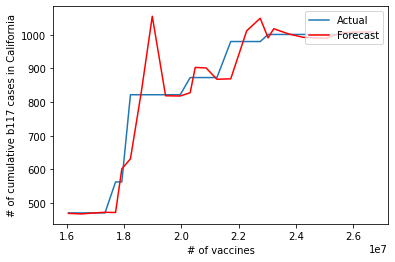

In [ ]:
variant_arima("California", "b117", 1, 2, 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=3.990179, expected=4.000000
predicted=3.976344, expected=4.000000
predicted=4.003372, expected=4.000000
predicted=4.014397, expected=4.000000
predicted=4.010299, expected=7.000000
predicted=8.623817, expected=7.000000
predicted=8.970869, expected=33.000000
predicted=35.620667, expected=33.000000
predicted=56.049988, expected=33.000000
predicted=32.877446, expected=33.000000
predicted=32.865087, expected=33.000000
predicted=33.247970, expected=34.000000
predicted=34.900955, expected=34.000000
predicted=34.350957, expected=34.000000
predicted=33.840803, expected=34.000000
predicted=33.853098, expected=39.000000
predicted=41.019120, expected=39.000000
predicted=41.696909, expected=39.000000
predicted=39.426832, expected=41.000000
predicted=42.256990, expected=41.000000
predicted=41.618390, expected=41.000000
predicted=40.698184, expected=41.000000
predicted=40.528993, expected=41.000000
predicted=41.233586, expected=41.000000
predicted=41.260315, expected=41.000000
predicted=41.

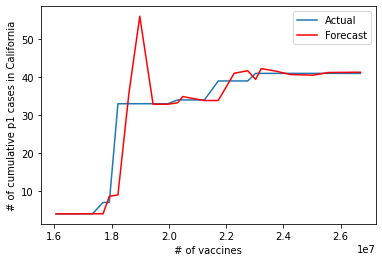

In [ ]:
variant_arima("California", "p1", 1, 2, 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=3.990301, expected=4.000000
predicted=3.976408, expected=4.000000
predicted=4.003637, expected=4.000000
predicted=4.014230, expected=4.000000
predicted=4.010197, expected=6.000000
predicted=7.157081, expected=6.000000
predicted=7.550197, expected=10.000000
predicted=10.118687, expected=10.000000
predicted=13.740511, expected=10.000000
predicted=9.963160, expected=10.000000
predicted=9.954015, expected=10.000000
predicted=10.072363, expected=10.000000
predicted=10.143014, expected=10.000000
predicted=9.960202, expected=10.000000
predicted=9.940546, expected=10.000000
predicted=9.957246, expected=14.000000
predicted=15.240873, expected=14.000000
predicted=16.896918, expected=14.000000
predicted=14.155109, expected=18.000000
predicted=19.854058, expected=18.000000
predicted=20.412148, expected=18.000000
predicted=17.864129, expected=18.000000
predicted=17.792958, expected=18.000000
predicted=18.099591, expected=18.000000
predicted=18.117309, expected=18.000000
predicted=18.12931

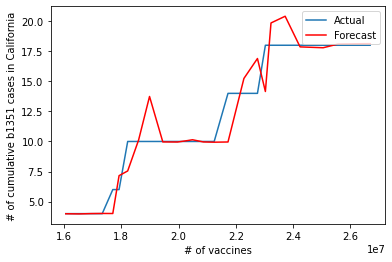

In [ ]:
variant_arima("California", "b1351", 1, 2, 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=3640747.921571, expected=3650159.000000
predicted=3628396.069338, expected=3652689.000000
predicted=3653877.282467, expected=3656131.000000
predicted=3670588.044619, expected=3658235.000000
predicted=3672878.744582, expected=3660137.000000
predicted=3698603.567306, expected=3663337.000000
predicted=3669889.743011, expected=3665401.000000
predicted=3647261.644662, expected=3667880.000000
predicted=3659484.118918, expected=3670484.000000
predicted=3656776.809782, expected=3674326.000000
predicted=3660813.591796, expected=3675318.000000
predicted=3702631.551177, expected=3675956.000000
predicted=3726539.736314, expected=3681944.000000
predicted=3670350.444362, expected=3684128.000000
predicted=3672779.689998, expected=3686576.000000
predicted=3667826.524540, expected=3688998.000000
predicted=3670877.749442, expected=3692641.000000
predicted=3702194.608293, expected=3695947.000000
predicted=3738171.500586, expected=3699411.000000
predicted=3735232.910104, expected=3703010.000000


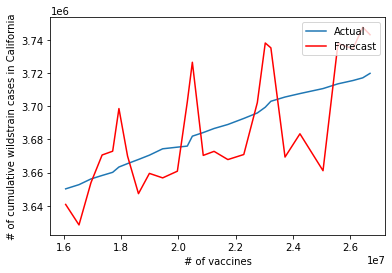

In [ ]:
# Strangely this does not seem to predict the covid wildstrains as well as it predicts the variants
variant_arima("California", "wildstrain", 2, 2, 0)